<a href="https://colab.research.google.com/github/JozefSL/pyNotes/blob/main/pymc3/pymc42with3models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
from google.colab import drive
import os
import sqlite3
import pymc as pm
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import rcParams
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import aesara

In [2]:
#import w
# %load_ext watermark
%pip install watermark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 8.9 MB/s 


In [3]:
%load_ext watermark

In [4]:
%watermark --iversions

aesara     : 2.7.9
arviz      : 0.12.1
pandas     : 1.3.5
seaborn    : 0.11.2
sqlite3    : 2.6.0
pymc       : 4.1.4
statsmodels: 0.12.2
matplotlib : 3.2.2
numpy      : 1.21.6
google     : 2.0.3



In [5]:
from google.colab import files
uploaded = files.upload()

Saving gridData4Hiro_EFandPerm.xlsx to gridData4Hiro_EFandPerm.xlsx


In [90]:
data = pd.read_excel('gridData4Hiro_EFandPerm.xlsx', sheet_name='Permian__42')

In [91]:
data.head()

,API15,feDate,drill_type,WaterGal,SandLB,LL,maxPo,maxPg,M6o,M6g,MHB,BasinID
0,130015473480000,2021-12-31,H,0.0,30527779.0,12602.0,1400.0,4278.0,43403.0,132618.0,DM72wa,42.0
1,142317434350000,2021-12-31,H,0.0,18546160.0,9984.0,1079.0,973.0,62375.0,57984.0,DM92cg,42.0
2,142317432230000,2021-12-31,H,17494192.0,18205932.0,9907.0,892.0,980.0,49720.0,48431.0,DM82xd,42.0
3,142317434340000,2021-12-31,H,0.0,20853694.0,10352.0,1033.0,1319.0,54381.0,65098.0,DM92cg,42.0
4,142329448730000,2021-12-31,H,17802078.0,15848508.0,10042.0,4649.0,1288.0,190781.0,50848.0,DM81wt,42.0


In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37074 entries, 0 to 37073
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   API15       37074 non-null  int64         
 1   feDate      37074 non-null  datetime64[ns]
 2   drill_type  36999 non-null  object        
 3   WaterGal    37069 non-null  float64       
 4   SandLB      35137 non-null  float64       
 5   LL          27501 non-null  float64       
 6   maxPo       36999 non-null  float64       
 7   maxPg       36999 non-null  float64       
 8   M6o         36999 non-null  float64       
 9   M6g         36999 non-null  float64       
 10  MHB         36999 non-null  object        
 11  BasinID     36999 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1), object(2)
memory usage: 3.4+ MB


In [93]:
data.drop(data[data.drill_type == 'V'].index, inplace=True)
data.drop(data[data.drill_type == 'D'].index, inplace=True)
data.drop(data[data.LL < 1].index, inplace=True)
data.drop(data[data.maxPo < 1].index, inplace=True)
data.drop(data[data.maxPg < 1].index, inplace=True)
data.drop(data[data.WaterGal < 1].index, inplace=True)
data.drop(data[data.WaterGal > 1.0e+08].index, inplace=True)
data.drop(data[data.SandLB < 1].index, inplace=True)
data.drop(data[data.SandLB > 1.0e+08].index, inplace=True)
data.drop(data[data.feDate < '2017-01-01'].index, inplace=True)
data.dropna(inplace=True)


In [94]:
data['YY'] = data['feDate'].dt.year

In [95]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19376 entries, 2 to 23254
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   API15       19376 non-null  int64         
 1   feDate      19376 non-null  datetime64[ns]
 2   drill_type  19376 non-null  object        
 3   WaterGal    19376 non-null  float64       
 4   SandLB      19376 non-null  float64       
 5   LL          19376 non-null  float64       
 6   maxPo       19376 non-null  float64       
 7   maxPg       19376 non-null  float64       
 8   M6o         19376 non-null  float64       
 9   M6g         19376 non-null  float64       
 10  MHB         19376 non-null  object        
 11  BasinID     19376 non-null  float64       
 12  YY          19376 non-null  int64         
dtypes: datetime64[ns](1), float64(8), int64(2), object(2)
memory usage: 2.1+ MB


In [96]:
Y_data = data.YY.unique()
Y_count = len(data.YY.unique())

In [97]:
M_names = data.MHB.unique()
M_count = len(data.MHB.unique())

M_names = pd.DataFrame(M_names, columns=['MHB'])
M_names = M_names.reset_index()
M_names.rename(columns={'index' : 'MHBn'}, inplace=True)

In [98]:
M_names.head()

,MHBn,MHB
0,0,DM82xd
1,1,DM81wt
2,2,DM81bn
3,3,DM81xl
4,4,DM82au


In [99]:
data = data.merge(M_names, on=['MHB'], how='left')

In [100]:
data = data.set_index('API15')

In [101]:
data

,feDate,drill_type,WaterGal,SandLB,LL,maxPo,maxPg,M6o,M6g,MHB,BasinID,YY,MHBn
API15,,,,,,,,,,,,,
142317432230000,2021-12-31,H,17494192.0,18205932.0,9907.0,892.0,980.0,49720.0,48431.0,DM82xd,42.0,2021,0
142329448730000,2021-12-31,H,17802078.0,15848508.0,10042.0,4649.0,1288.0,190781.0,50848.0,DM81wt,42.0,2021,1
142329448680000,2021-12-31,H,21536130.0,19502541.0,9889.0,493.0,151.0,17866.0,6552.0,DM81wt,42.0,2021,1
142329448700000,2021-12-31,H,17827992.0,15851707.0,9834.0,2626.0,678.0,88599.0,23569.0,DM81wt,42.0,2021,1
142389393680000,2021-12-31,H,16092930.0,21804760.0,8898.0,698.0,11011.0,42480.0,634655.0,DM81bn,42.0,2021,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
142227387600000,2017-01-01,H,12210156.0,18672696.0,8820.0,29.0,32.0,3774.0,3159.0,DM92fg,42.0,2017,520
142227387550000,2017-01-01,H,12217380.0,18836469.0,8819.0,604.0,717.0,71818.0,101195.0,DM92fg,42.0,2017,520
142389352040000,2017-01-01,H,19272678.0,23611847.0,9780.0,937.0,5078.0,125905.0,691623.0,DM81bn,42.0,2017,2


In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19376 entries, 142317432230000 to 142461403500000
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   feDate      19376 non-null  datetime64[ns]
 1   drill_type  19376 non-null  object        
 2   WaterGal    19376 non-null  float64       
 3   SandLB      19376 non-null  float64       
 4   LL          19376 non-null  float64       
 5   maxPo       19376 non-null  float64       
 6   maxPg       19376 non-null  float64       
 7   M6o         19376 non-null  float64       
 8   M6g         19376 non-null  float64       
 9   MHB         19376 non-null  object        
 10  BasinID     19376 non-null  float64       
 11  YY          19376 non-null  int64         
 12  MHBn        19376 non-null  int64         
dtypes: datetime64[ns](1), float64(8), int64(2), object(2)
memory usage: 2.1+ MB


In [103]:
#data['H2O_C'] = (data.WaterGal - data.WaterGal.mean())/1e6
#data['SAND_C'] = (data.SandLB - data.SandLB.mean())/1e6
#data['LL_C'] = (data.LL - data.LL.mean())/1e3

In [104]:
data1 = data[['maxPg', 'maxPo', 'LL', 'WaterGal', 'SandLB']].copy()
data1['WSL'] = (data1['WaterGal'] +data['SandLB'])/data['LL']

data1.describe().round(3)

,maxPg,maxPo,LL,WaterGal,SandLB,WSL
count,19376.000,19376.000,19376.000,1.937600e+04,1.937600e+04,19376.000
mean,2008.709,902.256,8542.983,1.684861e+07,1.799876e+07,4131.694
std,2026.086,512.474,2433.913,6.901703e+06,7.750857e+06,1834.719
min,1.000,1.000,380.000,1.000000e+00,7.000000e+00,0.593
25%,747.000,568.000,7150.000,1.193074e+07,1.311660e+07,3543.637
50%,1232.500,829.000,9514.500,1.723126e+07,1.767612e+07,4053.191
75%,2556.250,1141.000,10150.000,2.138608e+07,2.210341e+07,4648.332
max,23603.000,6167.000,20932.000,6.389993e+07,9.725454e+07,104766.412


In [105]:
#data1['maxPo.s'] = (data1['maxPo']-data1['maxPo'].mean())/(2*data1['maxPo'].std())
sData = (data1-data1.mean())/(2*data1.std()).copy()


In [106]:
sData.describe().round(3)

,maxPg,maxPo,LL,WaterGal,SandLB,WSL
count,19376.000,19376.000,19376.000,19376.000,19376.000,19376.000
mean,0.000,0.000,-0.000,0.000,0.000,0.000
std,0.500,0.500,0.500,0.500,0.500,0.500
min,-0.495,-0.879,-1.677,-1.221,-1.161,-1.126
25%,-0.311,-0.326,-0.286,-0.356,-0.315,-0.160
50%,-0.192,-0.071,0.200,0.028,-0.021,-0.021
75%,0.135,0.233,0.330,0.329,0.265,0.141
max,5.329,5.137,2.545,3.409,5.113,27.425


In [107]:
sData.head()

,maxPg,maxPo,LL,WaterGal,SandLB,WSL
API15,,,,,,
142317432230000,-0.253866,-0.010007,0.280211,0.046769,0.013365,-0.143937
142329448730000,-0.177857,3.655546,0.307944,0.069075,-0.138711,-0.212760
142329448680000,-0.458448,-0.399295,0.276513,0.339591,0.097007,0.004970
142329448700000,-0.328394,1.681787,0.265214,0.070952,-0.138504,-0.192638
142389393680000,2.221596,-0.199284,0.072931,-0.054746,0.245521,0.034727


In [108]:
wd = pd.merge(sData, data[['MHBn','YY']], how='left', left_index=True, right_index=True)

In [109]:
wd.head()

,maxPg,maxPo,LL,WaterGal,SandLB,WSL,MHBn,YY
API15,,,,,,,,
130005642410000,-0.374542,-0.400270,-0.820281,-0.990528,-0.915939,-0.708143,711,2017
130005642950000,-0.427847,-0.549546,-0.605195,-0.916830,-0.874822,-0.705738,249,2017
130005642960000,-0.472761,-0.683211,-0.943333,-0.970552,-0.904684,-0.613745,249,2021
130005643000000,-0.378984,-0.414905,-0.816994,-0.957546,-0.873990,-0.643623,176,2017
130005643010000,-0.369853,-0.360268,-0.778989,-0.924428,-0.815749,-0.584396,176,2018


In [110]:
MHB_idx = wd.MHBn.values
YY_idx = wd.YY.values

In [111]:
data.reset_index(inplace=True)

In [112]:
sData.reset_index(inplace=True)

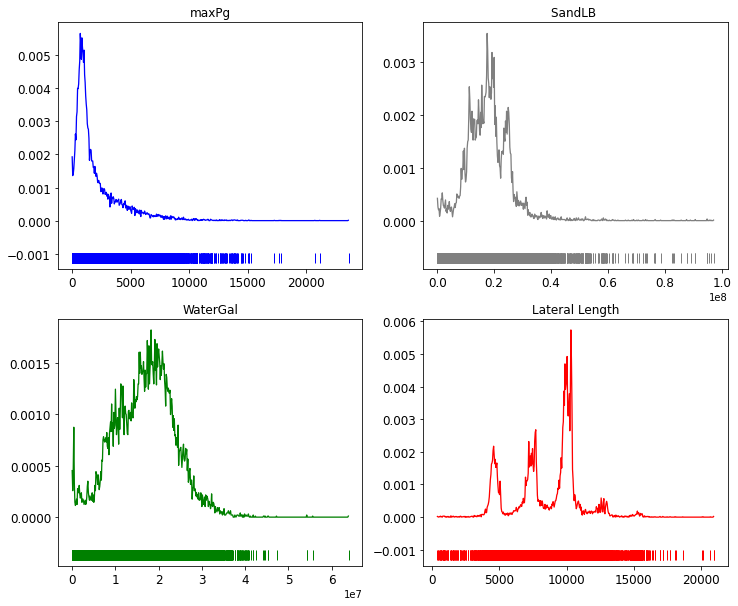

In [113]:
fig = plt.figure(figsize = (12,10))

ax1 = fig.add_subplot(2, 2, 1)
ax1.set_title('maxPg')
az.plot_kde(data['maxPg'],textsize=12, plot_kwargs={'color': 'b'}, rug=True, bw=2)

ax2 = fig.add_subplot(2, 2, 2)
ax2.set_title('SandLB ')
az.plot_kde(data['SandLB'],textsize=12, plot_kwargs={'color': 'gray'}, rug=True, bw=2)

ax3 = fig.add_subplot(2, 2, 3)
ax3.set_title('WaterGal')
az.plot_kde(data['WaterGal'],textsize=12, plot_kwargs={'color': 'green'}, rug=True, bw=2)

ax4 = fig.add_subplot(2, 2, 4)
ax4.set_title('Lateral Length')
az.plot_kde(data['LL'],textsize=12, plot_kwargs={'color': 'red'}, rug=True, bw=2);

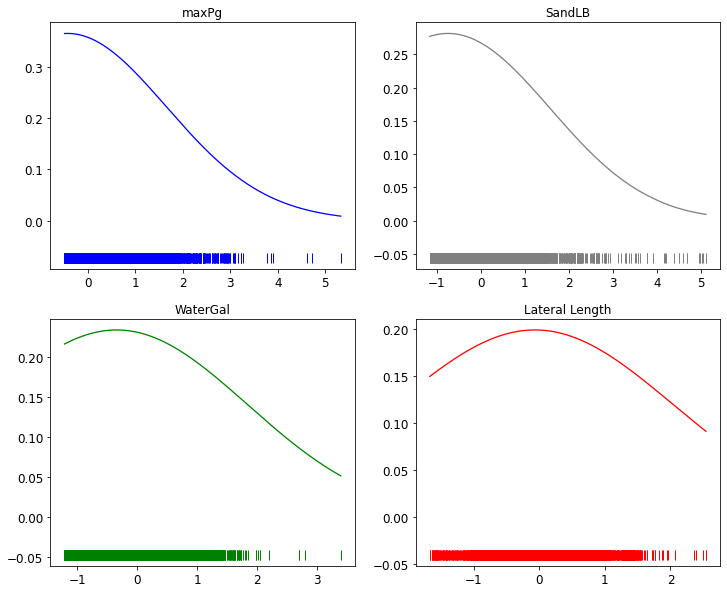

In [114]:
fig = plt.figure(figsize = (12,10))

ax1 = fig.add_subplot(2, 2, 1)
ax1.set_title('maxPg')
az.plot_kde(sData['maxPg'],textsize=12, plot_kwargs={'color': 'b'}, rug=True, bw=2)

ax2 = fig.add_subplot(2, 2, 2)
ax2.set_title('SandLB')
az.plot_kde(sData['SandLB'],textsize=12, plot_kwargs={'color': 'gray'}, rug=True, bw=2)

ax3 = fig.add_subplot(2, 2, 3)
ax3.set_title('WaterGal')
az.plot_kde(sData['WaterGal'],textsize=12, plot_kwargs={'color': 'green'}, rug=True, bw=2)

ax4 = fig.add_subplot(2, 2, 4)
ax4.set_title('Lateral Length')
az.plot_kde(sData['LL'],textsize=12, plot_kwargs={'color': 'red'}, rug=True, bw=2);

In [115]:
ls_1 = smf.ols('maxPg ~ WaterGal + SandLB + LL ', data=sData).fit()
ls_1.summary(alpha=0.11)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  maxPg   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     162.6
Date:                Fri, 21 Oct 2022   Prob (F-statistic):          4.22e-104
Time:                        14:16:18   Log-Likelihood:                -13821.
No. Observations:               19376   AIC:                         2.765e+04
Df Residuals:                   19372   BIC:                         2.768e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.055      0.945]
------------------------------------------------------------------------------
Intercept   3.123e-17      0.004    8.8e-15      1.000      -0.006       0.006
WaterGal      -0.0126      0.011     -1.187      0.235      -0.030       0.004
SandLB         0.1978      0.010     20.748      0.000       0.183       0.213
LL            -0.1109      0.010    -10.931      0.000      -0.127      -0.095
==============================================================================
Omnibus:                     9338.269   Durbin-Watson:                   1.614
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            60997.287
Skew:                           2.252   Prob(JB):                         0.00
Kurtosis:                      10.434   Cond. No.                         3.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [116]:
wd.tail()

,maxPg,maxPo,LL,WaterGal,SandLB,WSL,MHBn,YY
API15,,,,,,,,
142501373120000,-0.424639,-0.466615,-0.714278,-1.058390,-0.975290,-0.850585,161,2021
142501373180000,-0.441913,-0.338804,-0.701747,-0.969941,-0.940914,-0.760641,134,2021
142501373190000,-0.409585,-0.356366,-0.176461,-0.824794,-0.824322,-0.747055,94,2021
142501373260000,-0.425132,-0.318315,-0.176461,-0.871642,-0.824457,-0.770064,94,2021
142501373390000,-0.460422,-0.558327,-0.733383,-0.938592,-0.889745,-0.682146,134,2021


In [117]:
with pm.Model() as model_vi1:
# Priors
    μ_α = pm.Normal('μ_α', mu=0, sigma=0.5)
    σ_α = pm.Normal('σ_α', mu=0, sigma=0.5)
    # Random intercepts
    α = pm.Normal('α', mu=μ_α, sigma=σ_α, shape=M_count)
    # Common slope
    βw = pm.Normal('βw', mu=0, sigma=0.5)
    βs = pm.Normal('βs', mu=0, sigma=0.5)
    βh = pm.Normal('βh', mu=0, sigma=0.5)
   
    # Model error
    ϵ = pm.Normal('ϵ', mu=0, sigma=0.5)

    μ = α[MHB_idx] + βw*wd.WaterGal + βs*wd.SandLB + βh*wd.LL
    # Data likelihood
    maxPg = pm.Normal('maxPg', μ, ϵ, observed=wd.maxPg)

    trace_vi1 = pm.sample(2000, tune=1000, cores=2)

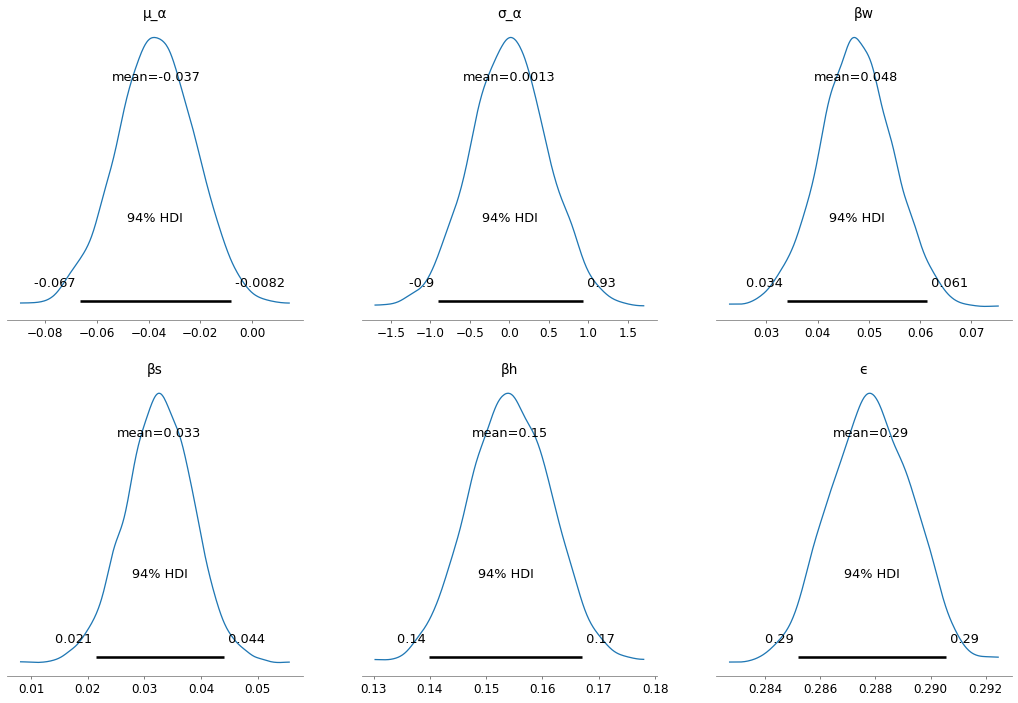

In [118]:
pm.plot_posterior(trace_vi1, var_names=['μ_α', 'σ_α', 'βw', 'βs', 'βh', 'ϵ'],
                  figsize=(18,12), textsize=12);

In [119]:
pm.summary(trace_vi1).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ_α,-0.04,0.02,-0.07,-0.01,0.0,0.00,8643.0,2777.0,1.0
σ_α,0.00,0.49,-0.90,0.93,0.0,0.01,9147.0,2229.0,1.0
α[0],-0.32,0.05,-0.41,-0.22,0.0,0.00,8772.0,2555.0,1.0
α[1],-0.29,0.03,-0.35,-0.22,0.0,0.00,9930.0,2444.0,1.0
α[2],1.26,0.04,1.18,1.34,0.0,0.00,8315.0,2594.0,1.0
...,...,...,...,...,...,...,...,...,...
α[1043],-0.22,0.25,-0.70,0.24,0.0,0.00,7373.0,2451.0,1.0
βw,0.05,0.01,0.03,0.06,0.0,0.00,4496.0,3259.0,1.0
βs,0.03,0.01,0.02,0.04,0.0,0.00,5419.0,3250.0,1.0
βh,0.15,0.01,0.14,0.17,0.0,0.00,4900.0,3262.0,1.0


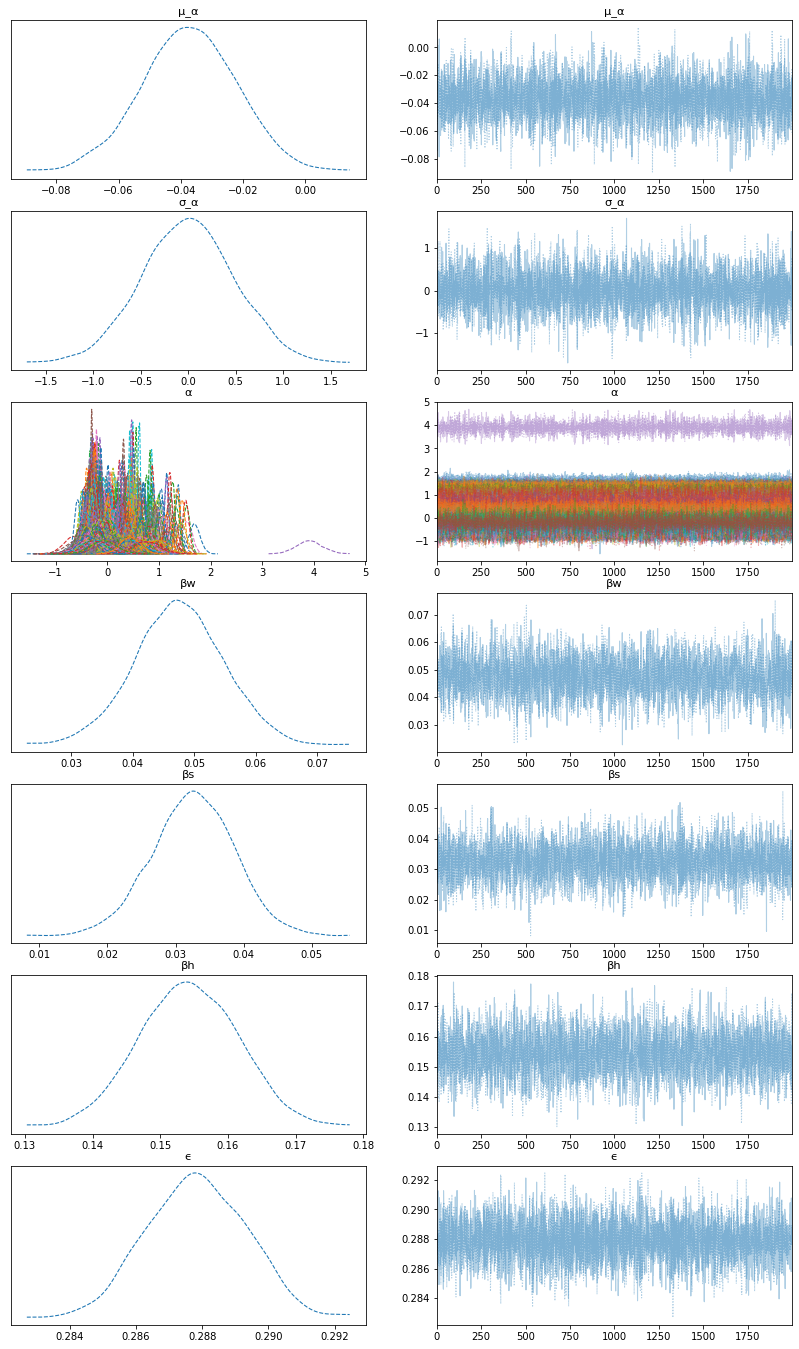

In [120]:
pm.plot_trace(trace_vi1, compact=True, combined=True, figsize=(14,24));


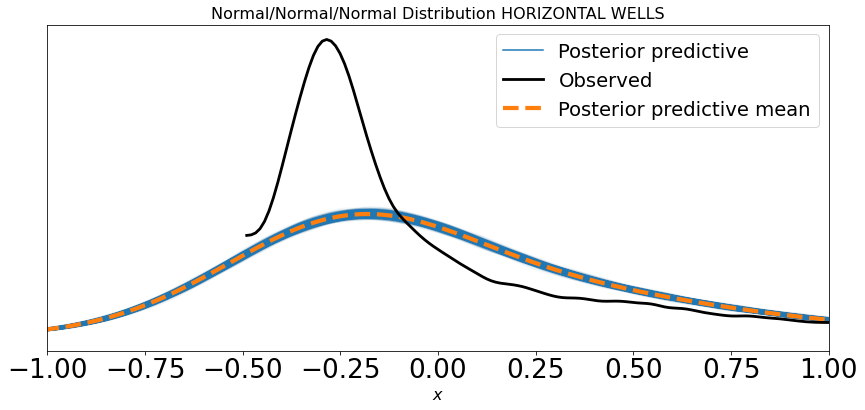

In [121]:
ppc1 = pm.sample_posterior_predictive(trace=trace_vi1, model=model_vi1)
az.plot_ppc(ppc1, alpha=0.03, figsize=(14, 6)) #, backend="bokeh")
plt.xlim(-1, 1)
plt.title("μ = α[MHB_idx] + βw*wd.WaterGal + βs*wd.SandLB + βh*wd.LL", fontsize=16)
plt.xlabel('$x$', fontsize=16);

In [122]:
with pm.Model() as modelHiro_v1:
# Priors
    μ_α = pm.Normal('μ_α', mu=0, sigma=0.5)
    σ_α = pm.Normal('σ_α', mu=0, sigma=0.5)
    # Random intercepts
    α = pm.Normal('α', mu=μ_α, sigma=0.5, shape=M_count)
    # Common slope
    #βw = pm.Normal('βw', mu=20, sigma=100)
    #βs = pm.Normal('βs', mu=-0.25, sigma=100)
    β = pm.Normal('β', mu=0, sigma=0.5, shape=M_count)
   
    # Model error
    ϵ = pm.Normal('ϵ', mu=1100, sigma=100)

    μ = α[MHB_idx] + β[MHB_idx]*wd.LL
    # Data likelihood
    maxPg = pm.Normal('maxPg', μ, ϵ, observed=wd.maxPg)

    traceHiro_v1 = pm.sample(2000, tune=1000, cores=2)

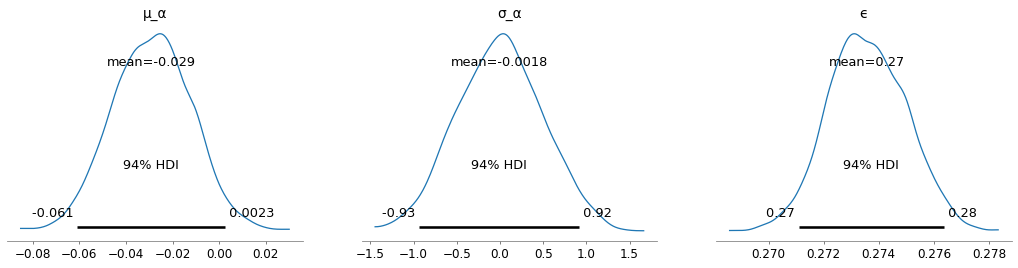

In [123]:
pm.plot_posterior(traceHiro_v1, var_names=['μ_α', 'σ_α', 'ϵ'],
                  figsize=(18,4), textsize=12);

In [124]:
pm.summary(traceHiro_v1).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ_α,-0.03,0.02,-0.06,0.00,0.0,0.00,7025.0,2945.0,1.0
σ_α,-0.00,0.50,-0.93,0.92,0.0,0.01,10172.0,2771.0,1.0
α[0],-0.30,0.05,-0.40,-0.20,0.0,0.00,9313.0,3035.0,1.0
α[1],-0.25,0.06,-0.36,-0.15,0.0,0.00,8968.0,2798.0,1.0
α[2],1.26,0.04,1.18,1.33,0.0,0.00,9145.0,2495.0,1.0
...,...,...,...,...,...,...,...,...,...
β[1040],-0.04,0.23,-0.50,0.38,0.0,0.00,7979.0,2624.0,1.0
β[1041],-0.15,0.38,-0.85,0.54,0.0,0.01,9327.0,3099.0,1.0
β[1042],0.08,0.41,-0.68,0.87,0.0,0.01,7082.0,3024.0,1.0
β[1043],0.19,0.43,-0.62,0.98,0.0,0.01,9098.0,3021.0,1.0


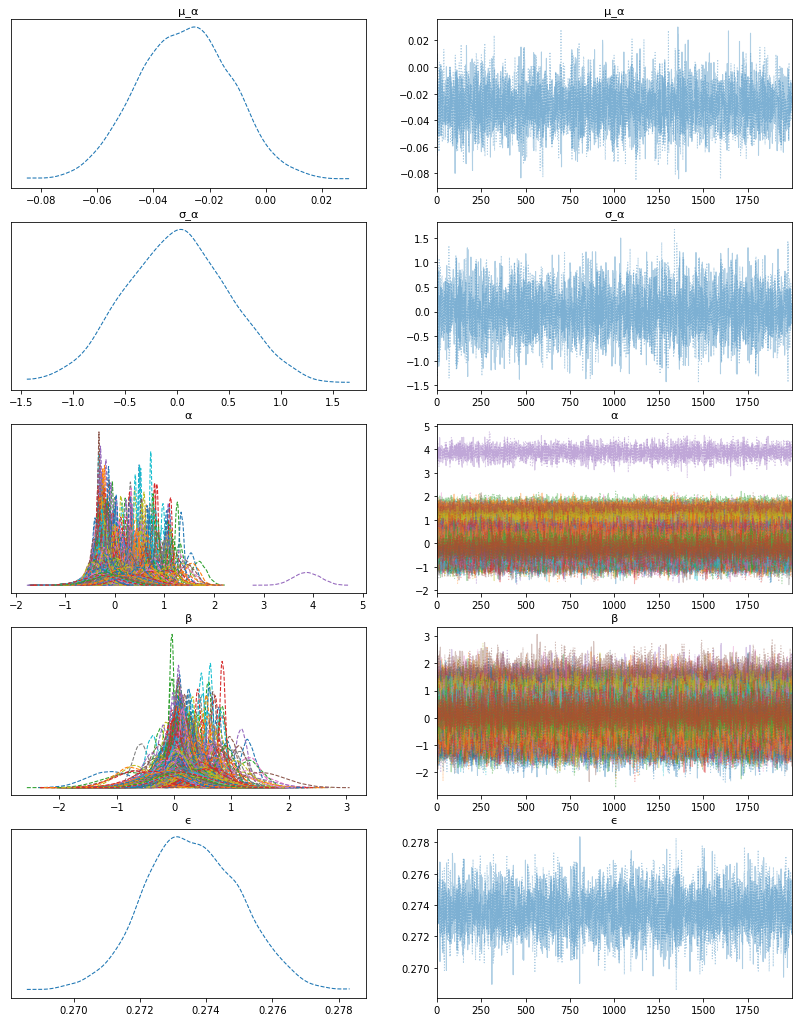

In [125]:
pm.plot_trace(traceHiro_v1, compact=True, combined=True, figsize=(14,18));

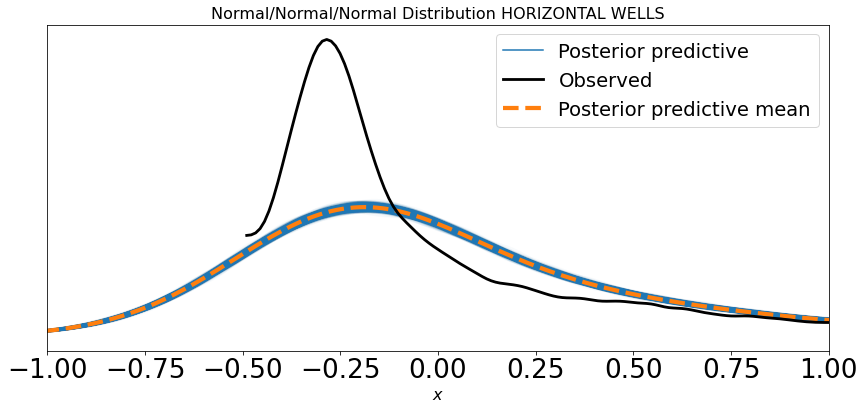

In [126]:
ppcH1 = pm.sample_posterior_predictive(trace=traceHiro_v1, model=modelHiro_v1)
az.plot_ppc(ppcH1, alpha=0.03, figsize=(14, 6)) #, backend="bokeh")
plt.xlim(-1, 1)
plt.title("μ = α[MHB_idx] + β[MHB_idx]*wd.LL", fontsize=16)
plt.xlabel('$x$', fontsize=16);

In [128]:
with pm.Model() as modelHiro_v2:
# Priors
    μ_α = pm.Normal('μ_α', mu=0, sigma=0.5)
    σ_α = pm.Normal('σ_α', mu=0, sigma=0.5)
    α = pm.Normal('α', mu=μ_α, sigma=σ_α, shape=M_count)
    
    μ_β = pm.Normal('μ_β', mu=0, sigma=0.5)
    σ_β = pm.Normal('σ_β', mu=0, sigma=0.5)    
    β = pm.Normal('β', mu=μ_β, sigma=σ_β, shape=M_count)
    
    γ = pm.Normal('γ', mu=0, sigma=0.5)

# Model error
    ϵ = pm.Normal('ϵ', mu=0, sigma=0.5)

    μ = α[MHB_idx] + (γ + β[MHB_idx]*wd.WSL)*wd.LL
# Data likelihood
    maxPg = pm.Normal('maxPg', μ, ϵ, observed=wd.maxPg)

    traceHiro_v2 = pm.sample(2000, tune=1000, cores=2)

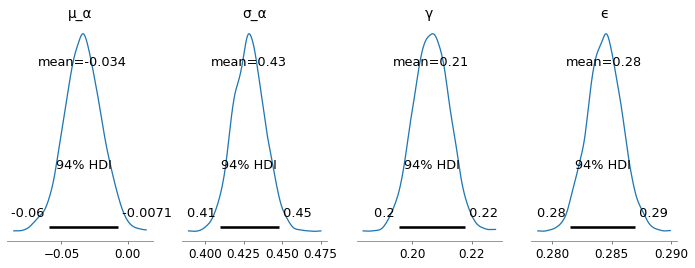

In [130]:
pm.plot_posterior(traceHiro_v2, var_names=['μ_α', 'σ_α', 'γ', 'ϵ'],
                  figsize=(12,4), textsize=12);

In [131]:
pm.summary(traceHiro_v2).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ_α,-0.03,0.01,-0.06,-0.01,0.0,0.0,4016.0,2633.0,1.0
σ_α,0.43,0.01,0.41,0.45,0.0,0.0,3346.0,2847.0,1.0
α[0],-0.32,0.05,-0.42,-0.22,0.0,0.0,3985.0,2675.0,1.0
α[1],-0.29,0.03,-0.35,-0.23,0.0,0.0,4853.0,2955.0,1.0
α[2],1.26,0.04,1.18,1.33,0.0,0.0,4466.0,2611.0,1.0
...,...,...,...,...,...,...,...,...,...
β[1041],-0.01,0.25,-0.49,0.47,0.0,0.0,4287.0,2561.0,1.0
β[1042],0.02,0.25,-0.45,0.50,0.0,0.0,4071.0,2503.0,1.0
β[1043],-0.04,0.25,-0.48,0.43,0.0,0.0,3612.0,2777.0,1.0
γ,0.21,0.01,0.20,0.22,0.0,0.0,2223.0,2611.0,1.0


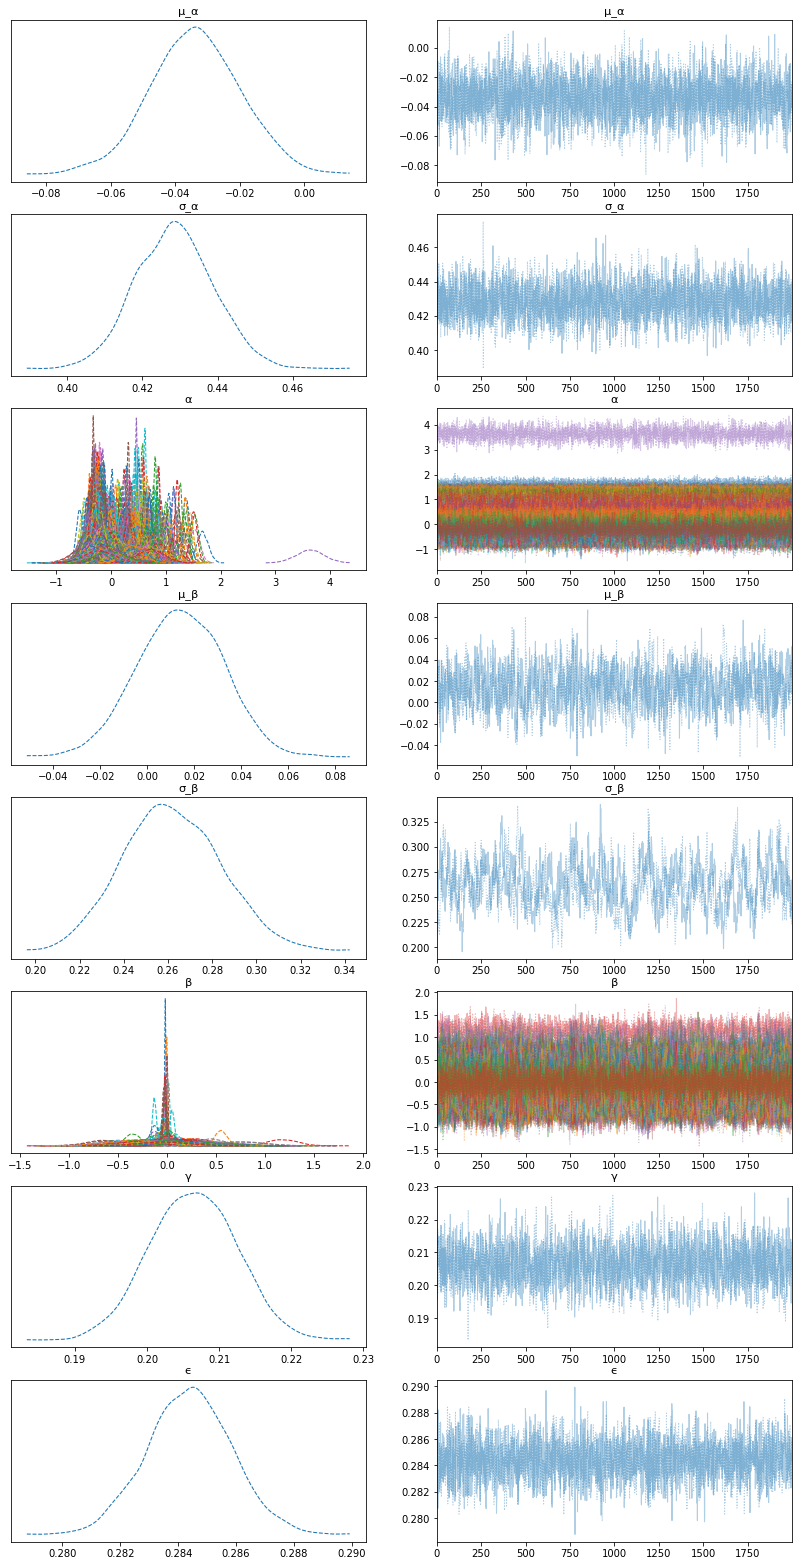

In [135]:
pm.plot_trace(traceHiro_v2, compact=True, combined=True, figsize=(14,28));

In [160]:
ppcH2test = pm.sample_posterior_predictive(trace=traceHiro_v2, var_names=["maxPg"], model=modelHiro_v2)
#ppc = pm.sample_posterior_predictive(trace_1, var_names=["a", "b", "obs"], random_seed=RANDOM_SEED

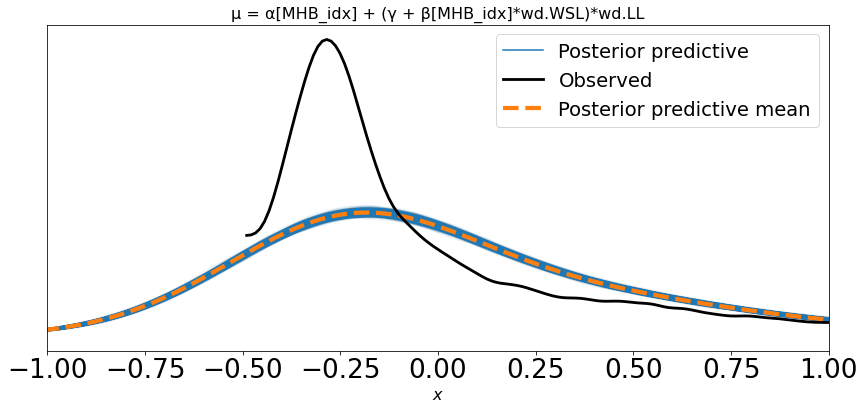

In [133]:
ppcH2 = pm.sample_posterior_predictive(trace=traceHiro_v2, model=modelHiro_v2)
az.plot_ppc(ppcH2, alpha=0.03, figsize=(14, 6)) #, backend="bokeh")
plt.xlim(-1, 1)
plt.title("μ = α[MHB_idx] + (γ + β[MHB_idx]*wd.WSL)*wd.LL", fontsize=16)
plt.xlabel('$x$', fontsize=16);

In [263]:
az.r2_score(np.array(wd.maxPg), ppc1.posterior_predictive.maxPg[0,:,:].values)  # μ = α[MHB_idx] + βw*wd.WaterGal + βs*wd.SandLB + βh*wd.LL

r2        0.600454
r2_std    0.002921
dtype: float64

In [261]:
az.r2_score(np.array(wd.maxPg), ppcH1.posterior_predictive.maxPg[0,:,:].values)   # μ = α[MHB_idx] + β[MHB_idx]*wd.LL

r2        0.626214
r2_std    0.002763
dtype: float64

In [262]:
az.r2_score(np.array(wd.maxPg), ppcH2.posterior_predictive.maxPg[0,:,:].values)   # μ = α[MHB_idx] + (γ + β[MHB_idx]*wd.WSL)*wd.LL

r2        0.604095
r2_std    0.002947
dtype: float64

In [ ]:
#wd.reset_index(inplace=True)

In [ ]:
#wd.head()

In [ ]:
#wd["maxPg"] = wd["maxPg"].astype(aesara.config.floatX)

In [ ]:
#wd["LL"] = wd["LL"].astype(aesara.config.floatX)

In [ ]:
#wd["WSL"] = wd["WSL"].astype(aesara.config.floatX)

In [ ]:
end

In [ ]:
with pm.Model() as modelHiro_v3:
# Priors
    #μ_α = pm.Normal('μ_α', mu=0, sigma=0.5)
    #σ_α = pm.Normal('σ_α', mu=0, sigma=0.5)
    #α = pm.Normal('α', mu=μ_α, sigma=0.5, shape=M_count)

    α = pm.Normal('α', mu=0, sigma=0.5, shape=M_count)
        
    β = pm.Normal('β', mu=0, sigma=0.5, shape=M_count)
    γ = pm.Normal('γ', mu=0, sigma=0.5, shape=Y_count)

    τ = pm.Normal('τ', mu=0, sigma=0.5, shape=Y_count)

# Model error
    ϵ = pm.Normal('ϵ', mu=0, sigma=0.5)

    μ = α[MHB_idx] + τ[YY_idx] + (γ[YY_idx] + β[MHB_idx]*wd.WSL)*wd.LL
# Data likelihood
    maxPg = pm.Normal('maxPg', μ, ϵ, observed=wd.maxPg)

    traceHiro_v3 = pm.sample(2000, tune=1000, cores=2)

In [ ]:
YY_idx

In [ ]:


vi1_est = pd.Series(trace_vi1['α'].mean(axis=0), index=M_names)
vi1_se = pd.Series(trace_vi1['α'].std(axis=0), index=M_names)
order = vi1_est.sort_values(ascending=False).index

plt.figure(figsize=(10,8))

plt.scatter(range(len(vi1_est)), vi1_est[order])
for i, m, se in zip(range(len(vi1_est)), vi1_est[order], vi1_se[order]):
    plt.plot([i,i], [m-se, m+se], 'b-', alpha = 0.3)
plt.xlim(-10,410); plt.ylim(-1000,6000)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.ylabel('α estimate', fontsize=16); plt.xlabel('Ordered Block', fontsize=16);

In [ ]:
# Varying Intercept Model, version ug
with pm.Model() as model_vi3:
    # Priors
    μ_α = pm.Normal('μ_α', mu=2125, sd=100)
    σ_α = pm.Normal('σ_α', mu=1725, sd=125)
    # Random intercepts
    α = pm.Gamma('α', mu=μ_α, sd=σ_α, shape=M_count)
    # Common slope
    βw = pm.Normal('βw', mu=18, sd=10)
    βs = pm.Normal('βs', mu=-0.25, sd=2)
    βh = pm.Normal('βh', mu=75, sd=25)
    
    # Model error
    ϵ = pm.Normal('ϵ', mu=1090,  sd=25)

    μ = μ = α[MHB_idx] + βw*wd.H2O_C + βs*wd.SAND_C + βh*wd.LL_C
    # Data likelihood
    maxPg = pm.Normal('maxPg', mu=μ, sd=ϵ, observed=wd.maxPg)
    
    trace_vi3 = pm.sample(2000, tune=1000, target_accept=0.90, cores=2)

In [ ]:
pm.plot_posterior(trace_vi3, var_names=['μ_α', 'σ_α', 'βw', 'βs', 'βh', 'ϵ'],
                  figsize=(12,12), textsize=12);

In [ ]:
pm.traceplot(trace_vi3, compact=True, combined=True)
pm.summary(trace_vi3).round(2)

In [ ]:
ppc3 = pm.sample_posterior_predictive(trace_vi3, 4000, model_vi3)
rcParams['figure.figsize'] = 14,6
ax = pm.kdeplot(data['maxPg'], plot_kwargs={'color': 'blue'}, bw=3, rug=True)
az.plot_kde(ppc3['maxPg'], plot_kwargs={'color': 'red'}, ax=ax, bw=2)
plt.xlim(-200, 18000)
plt.title("Normal/Gamma/Normal Distribution HORIZONTAL WELLS", fontsize=16)
plt.xlabel('$x$', fontsize=16);

In [ ]:
az.r2_score(np.array(data.maxPg), ppc3['maxPg'])

In [ ]:
vi3_est = pd.Series(trace_vi3['α'].mean(axis=0), index=M_names)
vi3_se = pd.Series(trace_vi3['α'].std(axis=0), index=M_names)
order = vi3_est.sort_values(ascending=False).index

plt.figure(figsize=(10,8))
plt.scatter(range(len(vi3_est)), vi3_est[order])
for i, m, se in zip(range(len(vi3_est)), vi3_est[order], vi3_se[order]):
    plt.plot([i,i], [m-se, m+se], 'b-', alpha = 0.3)
plt.xlim(-10,410); plt.ylim(0,7000)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.ylabel('alpha estimate', fontsize=16); plt.xlabel('Ordered Block', fontsize=16);

Multi-level Model Modifications

In [ ]:
maxPg_avg = pm.sample_posterior_predictive_w([trace_vi1, trace_vi3], samples=1000,
                                        models=[model_vi1, model_vi3])

In [ ]:
rcParams['figure.figsize'] = 14,6
ax = pm.kdeplot(data['maxPg'], plot_kwargs={'color': 'blue'}, bw=2, rug=True)
az.plot_kde(maxPg_avg['maxPg'], plot_kwargs={'color': 'red'}, ax=ax, bw=2)
plt.xlim(-200, 18000)
plt.title("Average Distribution Likelihood HORIZONTAL WELLS", fontsize=16)
plt.xlabel('$x$', fontsize=16);

In [ ]:
az.r2_score(np.array(data.maxPg), maxPg_avg['maxPg'])

In [ ]:
_, ax = plt.subplots(figsize=(14,7))
az.plot_kde(data['maxPg'], plot_kwargs={'color': 'b'}, label='kde maxPo', bw=5)
az.plot_kde(ppc1['maxPg'], plot_kwargs={'color': 'C1'}, label='N_N_N', ax=ax)
az.plot_kde(ppc3['maxPg'], plot_kwargs={'color': 'C2'}, label='N_G_N', ax=ax)
#az.plot_kde(ppc5['maxPg'], plot_kwargs={'color': 'C3'}, label='TN_N_N', ax=ax)
az.plot_kde(maxPg_avg['maxPg'], plot_kwargs={'color': 'C4'}, label='weighted model', ax=ax)
plt.xlim(-200, 18000)
plt.plot(data['maxPg'], np.zeros_like(data['maxPg']), '|', label='observed data')
#plt.yticks([])
plt.ylim(-0.0001, 0.003)
plt.legend();

In [ ]:
cmp_df = az.compare({'model_ls':trace_ls, 'model_vi1':trace_vi1, 'model_vi3':trace_vi3},
                    method='BB-pseudo-BMA')
cmp_df

In [ ]:
az.plot_compare(cmp_df, figsize=(8,6));

Output Coding

In [ ]:
modA = data[['maxPg', 'maxPo', 'LL_C', 'H2O_C', 'SAND_C', 'MHB', 'API15']].groupby(['MHB']).mean()
modA.drop('API15', axis=1, inplace=True)
modA2 = data[['MHB','API15']].groupby(['MHB']).count()
modA2.columns = ['wellCnt']
modA = modA.sort_values(by=['maxPg'], ascending=False)
modA = modA2.join(modA ,how = 'left').sort_values(by=['maxPg'], ascending=False)

In [ ]:
vi1_est = pd.Series(trace_vi1['α'].mean(axis=0), index=M_names.MHB)
dfM1 = pd.DataFrame(vi1_est)
dfM1.columns = ['am1']
modA1 = dfM1.join(modA ,how = 'left').sort_values(by=['maxPg'], ascending=False)

dfM2 = pd.DataFrame(pd.Series(trace_vi3['α'].mean(axis=0), index=M_names.MHB))
dfM2.columns = ['am3']
modA2 = dfM2.join(modA1 ,how = 'left').sort_values(by=['maxPg'], ascending=False)



modA2['a0']=modA2['maxPg']
modA2['a1']=modA2['am1']
modA2['a3']=modA2['am3']


def mnormalize(df, ncols):
    df = df.copy()
    for i in ncols:
        if df[i].min() < 0:
            df[i] = (df[i] - df[i].min())
            df[i] = (df[i]/df[i].max())
        else: 
            df[i] = (df[i]/df[i].max())
    return df

ncols = ['a0','a1','a3']
modA2.sort_index(inplace=True)
nmodA2 = mnormalize(modA2, ncols)
nmodA2.head()

In [ ]:
vi1var= pm.backends.tracetab.trace_to_dataframe(trace_vi1, varnames=['βw', 'βs', 'βh'])
vi3var= pm.backends.tracetab.trace_to_dataframe(trace_vi3, varnames=['βw', 'βs', 'βh'])
#vi5var= pm.backends.tracetab.trace_to_dataframe(trace_vi5, varnames=['βw', 'βs', 'βh'])
mVar = pd.DataFrame()
mVar['m1'] = vi1var.mean()
mVar['m3'] = vi3var.mean()
#mVar['m5'] = vi5var.mean()

mVar

In [ ]:
nmodA2['m1Pg'] = nmodA2['am1'] + nmodA2[['H2O_C','SAND_C','LL_C']].mul(mVar['m1'].values, axis = 1).sum(axis=1)
nmodA2['m3Pg'] = nmodA2['am3'] + nmodA2[['H2O_C','SAND_C','LL_C']].mul(mVar['m3'].values, axis = 1).sum(axis=1)

nmodA2.head(15)